In [53]:
import numpy as np
from pydgrid.pydgrid import grid
from pydgrid.plot_bokeh import plot_results
import sympy as sym
import pydae.build as db
from pydae.grid_urisi import unb_ri_si
from pydae.models import dcgrid2dae,dcrail2dae
from pydae.tools import get_v,get_i,get_s,save,load
from pydae.train_tools import trains_update,trains2params
import json
import matplotlib.pyplot as plt

## Grid building

In [35]:
grid_data = {
        "buses":[
                 {"bus": "B1",  "pos_x":   0, "pos_y":  0, "units": "m", "U_kV":20.0},
                 {"bus": "B2",  "pos_x":  50, "pos_y":  0, "units": "m", "U_kV":20.0},
                 {"bus": "B3",  "pos_x": 100, "pos_y":  0, "units": "m", "U_kV":20.0},
                 {"bus": "B4",  "pos_x": 150, "pos_y":  0, "units": "m", "U_kV":20.0},
                 {"bus": "B5",  "pos_x": 200, "pos_y":  0, "units": "m", "U_kV":20.0},
                 {"bus": "B6",  "pos_x": 250, "pos_y":  0, "units": "m", "U_kV":20.0},
                 {"bus": "B7",  "pos_x": 350, "pos_y":  0, "units": "m", "U_kV":20.0},
                 {"bus": "B2lv",  "pos_x": 50, "pos_y":  -10, "units": "m", "U_kV":1.5},
                 {"bus": "B3lv",  "pos_x": 100, "pos_y": -10, "units": "m", "U_kV":1.5},
                 {"bus": "B4lv",  "pos_x": 150, "pos_y": -10, "units": "m", "U_kV":1.5},
                 {"bus": "B5lv",  "pos_x": 200, "pos_y": -10, "units": "m", "U_kV":1.5},
                 {"bus": "B6lv",  "pos_x": 250, "pos_y": -10, "units": "m", "U_kV":1.5},
                ],
        "grid_formers":[
                        {"bus": "B1",
                        "bus_nodes": [1, 2, 3], "deg": [0, -120, -240],
                        "kV": [20.0/np.sqrt(3), 20.0/np.sqrt(3), 20.0/np.sqrt(3)]},
                        {"bus": "B7",
                        "bus_nodes": [1, 2, 3], "deg": [0, -120, -240],
                        "kV": [20.0/np.sqrt(3), 20.0/np.sqrt(3), 20.0/np.sqrt(3)]},
                       ],
        "lines":[
                 {"bus_j": "B1",  "bus_k": "B2",  "code": "mv_al_185", "m": 2600,'monitor':True},
                 {"bus_j": "B2",  "bus_k": "B3",  "code": "mv_al_185", "m": 2600,'monitor':True},
                 {"bus_j": "B3",  "bus_k": "B4",  "code": "mv_al_185", "m": 2600,'monitor':True},
                # {"bus_j": "B4",  "bus_k": "B5",  "code": "mv_al_185", "m": 2600,'monitor':True},
                 {"bus_j": "B5",  "bus_k": "B6",  "code": "mv_al_185", "m": 2600,'monitor':True},
                 {"bus_j": "B6",  "bus_k": "B7",  "code": "mv_al_185", "m": 2600,'monitor':True},
                ],
"transformers":[
        {"bus_j": "B2",  "bus_k": "B2lv",
        "S_n_kVA": 2200.0, "U_j_kV":20.0, "U_k_kV":1.5,
        "R_cc_pu": 0.01, "X_cc_pu":0.04, "connection": "Dyn11",
  "conductors_j": 3, "conductors_k": 4, "monitor":True},
        {"bus_j": "B3",  "bus_k": "B3lv",
        "S_n_kVA": 2200.0, "U_j_kV":20.0, "U_k_kV":1.5,
        "R_cc_pu": 0.01, "X_cc_pu":0.04, "connection": "Dyn11",
  "conductors_j": 3, "conductors_k": 4, "monitor":True},
        {"bus_j": "B4",  "bus_k": "B4lv",
        "S_n_kVA": 2200.0, "U_j_kV":20.0, "U_k_kV":1.5,
        "R_cc_pu": 0.01, "X_cc_pu":0.04, "connection": "Dyn11",
  "conductors_j": 3, "conductors_k": 4, "monitor":True},
        {"bus_j": "B5",  "bus_k": "B5lv",
        "S_n_kVA": 2200.0, "U_j_kV":20.0, "U_k_kV":1.5,
        "R_cc_pu": 0.01, "X_cc_pu":0.04, "connection": "Dyn11",
  "conductors_j": 3, "conductors_k": 4, "monitor":True},
        {"bus_j": "B6",  "bus_k": "B6lv",
        "S_n_kVA": 2200.0, "U_j_kV":20.0, "U_k_kV":1.5,
        "R_cc_pu": 0.01, "X_cc_pu":0.04, "connection": "Dyn11",
         "conductors_j": 3, "conductors_k": 4, "monitor":True}
        ],
        "loads":[
                 {"bus": "B2lv" , "kVA": [740.0,740.0,740.0], "pf":[0.9]*3,"type":"3P+N"},
                 {"bus": "B3lv" , "kVA": [740.0,740.0,740.0], "pf":[0.9]*3,"type":"3P+N"},
                 {"bus": "B4lv" , "kVA": [740.0,740.0,740.0], "pf":[0.9]*3,"type":"3P+N"},
                 {"bus": "B5lv" , "kVA": [740.0,740.0,740.0], "pf":[0.9]*3,"type":"3P+N"},
                 {"bus": "B6lv" , "kVA": [740.0,740.0,740.0], "pf":[0.9]*3,"type":"3P+N"}
                ],
        "shunts":[
                 {"bus": "B2lv" , "R": 0.001, "X": 0.0, "bus_nodes": [4,0]},
                 {"bus": "B3lv" , "R": 0.001, "X": 0.0, "bus_nodes": [4,0]},
                 {"bus": "B4lv" , "R": 0.001, "X": 0.0, "bus_nodes": [4,0]},
                 {"bus": "B5lv" , "R": 0.001, "X": 0.0, "bus_nodes": [4,0]},
                 {"bus": "B6lv" , "R": 0.001, "X": 0.0, "bus_nodes": [4,0]}
                 ],
        "line_codes":
            {
                "lv_cu_150":  {"Rph":0.167,"Xph":0.08, "Rn":0.167, "Xn": 0.08},
                "mv_al_150":   {"R1":0.262,  "X1":0.118, "C_1_muF":0.250 },
                "mv_al_185":   {"R1":0.209,  "X1":0.113, "C_1_muF":0.281 },
                "mv_al_240":   {"R1":0.161,  "X1":0.109, "C_1_muF":0.301 },
                "mv_al_300":   {"R1":0.128,  "X1":0.105, "C_1_muF":0.340 }
            }
       }

In [36]:
grid_1 = grid()
grid_1.read(grid_data)  # Load data
grid_1.pf()  # solve power flow
p=plot_results(grid_1)


In [37]:
grid_mv = unb_ri_si(grid_data)

params_dict  = grid_mv.dae['params']
f_list = grid_mv.dae['f']
x_list = grid_mv.dae['x']
g_list = grid_mv.dae['g'] 
y_list = grid_mv.dae['y'] 
u_dict = grid_mv.dae['u']


h_dict = grid_mv.dae['h_v_m_dict']

sys_dict = {'name':'grid_mv',
           'params_dict':params_dict,
           'f_list':f_list,
           'g_list':g_list,
           'x_list':x_list,
           'y_ini_list':y_list,
           'y_run_list':y_list,
           'u_run_dict':u_dict,
           'u_ini_dict':u_dict,
           'h_dict':h_dict
           }

db.system(sys_dict)
db.sys2num(sys_dict)

data = json.dumps(grid_mv.dae['xy_0_dict'], indent=4)
fobj = open("grid_mv_xy_0_dict.json","w")
fobj.write(data)
fobj.close()

system without dynamic equations, adding dummy dynamic equation


In [38]:
Y_ii = grid_1.Y_ii.toarray()
Y_vv = grid_1.Y_vv
Y_vi = grid_1.Y_vi
inv_Y_ii = np.linalg.inv(Y_ii)
N_nz_nodes = grid_1.params_pf[0].N_nz_nodes
N_v = grid_1.params_pf[0].N_nodes_v
nodes_list = grid_1.nodes
Y_primitive = grid_1.Y_primitive_sp.toarray() 
A_conect = grid_1.A_sp.toarray()
node_sorter  = grid_1.node_sorter
N_v = grid_1.N_nodes_v

np.savez('matrices',Y_primitive=Y_primitive,A_conect=A_conect,nodes_list=nodes_list,
         node_sorter=node_sorter,N_v=N_v, Y_vv=Y_vv, Y_vi=Y_vi)


with open("grid_data.json", "w") as fobj:
    json.dump(grid_1.data, fobj, indent=4, sort_keys=True)


## Railway building

In [39]:
data_input = load('trains_lv_5vsc_params.json')   # See at the end of the notebook for .json creation

In [40]:
dcgrid_dae = dcgrid2dae(data_input)  # Creates the DC grid from data_input
dcrail2dae(data_input,dcgrid_dae)    # Modify the DC grid with the railway particularities

In [41]:
rho = 1.72e-8    # copper conductivity
s = 300.0/1.0e6  # conductor section m^2
r_m = rho/s  # Ohm/m  
    
sections = data_input['sections']
trains = data_input['trains']
trips = data_input['trips']

for trip in trips:    # converts json list to np.array
    trips[trip]['times'] = np.array(trips[trip]['times'])
    trips[trip]['positions'] = np.array(trips[trip]['positions'])
    trips[trip]['powers'] = np.array(trips[trip]['powers'])
    
t=60*2
train_positions_list,train_powers_list = trains_update(t,trains,trips)           # for the given t this creates a list
                                                                                 # of train positions and their respective
                                                                                 # powers
params_dict_trains,nodes_dict = trains2params(sections,train_positions_list,train_powers_list,r_m)   # for the given trains the topology in defined


In [42]:
f_list = dcgrid_dae['f']
g_list = dcgrid_dae['g']
y_list = dcgrid_dae['y']
x_list = dcgrid_dae['x']
u_run_dict = {'Dv_r_13':0.0,'Dv_r_23':0.0,'Dv_r_33':0.0,'Dv_r_43':0.0,'Dv_r_53':0.0}
u_run_dict.update({'v_nom':3e3,'T_v':0.02,'K_r':0.05*3e3/500e3})
h_dict = dcgrid_dae['h_dict']

sys = {'name':f"railway_5vsc",
       'params_dict':params_dict_trains,
       'f_list':f_list,
       'g_list':g_list,
       'x_list':x_list,
       'y_ini_list':y_list,
       'y_run_list':y_list,
       'u_run_dict':u_run_dict,
       'u_ini_dict':u_run_dict,
       'h_dict':h_dict
      }

sys = db.system(sys)
db.sys2num(sys)

## Grid and railway interaction

In [43]:
params_dict  = grid_mv.dae['params']
params_dict.update(params_dict_trains)
f_list = grid_mv.dae['f'] + dcgrid_dae['f']
x_list = grid_mv.dae['x'] + dcgrid_dae['x']
g_list = grid_mv.dae['g'] + dcgrid_dae['g']
y_list = grid_mv.dae['y'] + dcgrid_dae['y']
u_dict = grid_mv.dae['u'] 
u_dict.update({'Dv_r_13':0.0,'Dv_r_23':0.0,'Dv_r_33':0.0,'Dv_r_43':0.0,'Dv_r_53':0.0})
u_dict.update({'v_nom':3e3,'T_v':0.02,'K_r':0.05*3e3/500e3})
h_dict = dcgrid_dae['h_dict']

ac_dc_buses = [('B2lv','13'),('B3lv','23'),('B4lv','33'),('B5lv','43'),('B6lv','53')]

for bus_ac,bus_dc in ac_dc_buses:

    p_a,p_b,p_c = sym.symbols(f'p_{bus_ac}_a,p_{bus_ac}_b,p_{bus_ac}_c', real=True)
    i_dc,v_dc = sym.symbols(f'i_{bus_dc},v_{bus_dc}', real=True)
    i_a_r,i_a_i = sym.symbols(f'i_load_{bus_ac}_a_r,i_load_{bus_ac}_a_i', real=True)
    a,b,c = sym.symbols(f'a_{bus_ac},b_{bus_ac},c_{bus_ac}', real=True)
    
    i_rms = sym.sqrt(i_a_r**2+i_a_i**2+1) 
    
    p_simple = a + b*i_rms + c*i_rms*i_rms

    p_vsc_loss = p_simple*6
    
    p_d = i_dc*v_dc
    
    p_dc = p_d + sym.Piecewise((p_vsc_loss, p_d < 1), (p_vsc_loss, p_d > 0),(0.0, True))
    p_ac = p_dc
    
    g_list += [p_a + p_ac/3]
    g_list += [p_b + p_ac/3] 
    g_list += [p_c + p_ac/3] 
    
    y_list += [p_a]
    y_list += [p_b]
    y_list += [p_c]
    
    u_dict.update({f'a_{bus_ac}':2.92075867})
    u_dict.update({f'b_{bus_ac}':0.44961794})
    u_dict.update({f'c_{bus_ac}':0.02717091})
    
    u_dict.pop(str(p_a))
    u_dict.pop(str(p_b))
    u_dict.pop(str(p_c))

In [44]:

sys = {'name':f"grid_railway_5vsc",
       'params_dict':params_dict,
       'f_list':f_list,
       'g_list':g_list,
       'x_list':x_list,
       'y_ini_list':y_list,
       'y_run_list':y_list,
       'u_run_dict':u_dict,
       'u_ini_dict':u_dict,
       'h_dict':h_dict
      }

sys = db.system(sys)
db.sys2num(sys)

In [45]:
xy_0_dict = grid_mv.dae['xy_0_dict']
xy_0_dict.update(dcgrid_dae['xy_0_dict'])

In [46]:
data = json.dumps(xy_0_dict, indent=4)
fobj = open("xy_0_dict.json","w")
fobj.write(data)
fobj.close()

In [47]:
u_dict

{'v_B1_a_r': 11547.005383792517,
 'v_B1_a_i': 0.0,
 'v_B1_b_r': -5773.502691896256,
 'v_B1_b_i': -10000.000000000002,
 'v_B1_c_r': -5773.502691896264,
 'v_B1_c_i': 10000.0,
 'v_B7_a_r': 11547.005383792517,
 'v_B7_a_i': 0.0,
 'v_B7_b_r': -5773.502691896256,
 'v_B7_b_i': -10000.000000000002,
 'v_B7_c_r': -5773.502691896264,
 'v_B7_c_i': 10000.0,
 'i_B2lv_n_r': 5.684341886080802e-14,
 'i_B2lv_n_i': 1.2505552149377763e-12,
 'i_B3lv_n_r': -3.979039320256561e-13,
 'i_B3lv_n_i': 1.2505552149377763e-12,
 'i_B4lv_n_r': -3.979039320256561e-13,
 'i_B4lv_n_i': 1.1368683772161603e-12,
 'i_B5lv_n_r': -8.526512829121202e-13,
 'i_B5lv_n_i': 3.410605131648481e-13,
 'i_B6lv_n_r': -2.8421709430404007e-13,
 'i_B6lv_n_i': 4.547473508864641e-13,
 'i_B2_a_r': 0.0,
 'i_B2_a_i': 0.0,
 'i_B2_b_r': 0.0,
 'i_B2_b_i': 0.0,
 'i_B2_c_r': 0.0,
 'i_B2_c_i': 0.0,
 'i_B3_a_r': 0.0,
 'i_B3_a_i': 0.0,
 'i_B3_b_r': 0.0,
 'i_B3_b_i': 0.0,
 'i_B3_c_r': 0.0,
 'i_B3_c_i': 0.0,
 'i_B4_a_r': 0.0,
 'i_B4_a_i': 0.0,
 'i_B4_b_r': 0

### Railway data building

In [49]:
import numpy as np
railway_pos_ini = 0.0e3
railway_pos_end = 13.0e3
xend = railway_pos_end
data_input = {
    "system":{"f_hz":50,"model_type":"ae"},
    "buses":[{'bus':'11'},{'bus':'12'},{'bus':'13'},{'bus':'14'},{'bus':'15'},
             {'bus':'21'},{'bus':'22'},{'bus':'23'},{'bus':'24'},{'bus':'25'},
             {'bus':'31'},{'bus':'32'},{'bus':'33'},{'bus':'34'},{'bus':'35'},
             {'bus':'41'},{'bus':'42'},{'bus':'43'},{'bus':'44'},{'bus':'45'},
             {'bus':'51'},{'bus':'52'},{'bus':'53'},{'bus':'54'},{'bus':'55'},],
    "lines":    [  
                {"bus_j":"11", "bus_k":"12", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":2.82},
                {"bus_j":"12", "bus_k":"13", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":4.42},
                {"bus_j":"13", "bus_k":"14", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"14", "bus_k":"15", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"21", "bus_k":"22", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":2.82},
                {"bus_j":"22", "bus_k":"23", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":4.42},
                {"bus_j":"23", "bus_k":"24", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"24", "bus_k":"25", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"31", "bus_k":"32", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":2.82},
                {"bus_j":"32", "bus_k":"33", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":4.42},
                {"bus_j":"33", "bus_k":"34", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"34", "bus_k":"35", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"41", "bus_k":"42", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":2.82},
                {"bus_j":"42", "bus_k":"43", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":4.42},
                {"bus_j":"43", "bus_k":"44", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"44", "bus_k":"45", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"51", "bus_k":"52", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":2.82},
                {"bus_j":"52", "bus_k":"53", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":4.42},
                {"bus_j":"53", "bus_k":"54", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"54", "bus_k":"55", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61},
                {"bus_j":"15", "bus_k":"21", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":2.82}, # module link
                {"bus_j":"25", "bus_k":"31", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":4.42}, # module link
                {"bus_j":"35", "bus_k":"41", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61}, # module link
                {"bus_j":"45", "bus_k":"51", "R_km":0.501, "X_km":0.716, "B_muS_km":47.493, "km":0.61}, # module link
             ],
"loads" : [
        #{"bus": "12", "kVA":0e3, "pf": 0.95, "T_i":0.01,"I_max":1200},
        #{"bus": "13", "kVA":0e3, "pf": 0.95, "T_i":0.01,"I_max":1200},
        #{"bus": "14", "kVA":0e3, "pf": 0.95, "T_i":0.01,"I_max":1200}
        ],
"trains":[{'t_ini':0, 'direction':'right', 'trip':'right'},   # T1 llega a B 130
          {'t_ini':2, 'direction':'right', 'trip':'right'},  # T3 llega a B 160
          {'t_ini':10, 'direction':'right', 'trip':'right'},  # T5 llega a B 220
          {'t_ini':15, 'direction':'right', 'trip':'right'}, # T2 
          {'t_ini':20, 'direction':'right', 'trip':'right'}, # T4
          {'t_ini':0, 'direction':'left', 'trip':'left'},   # T2
          {'t_ini':5, 'direction':'left', 'trip':'left'},   # T4
          {'t_ini':10, 'direction':'left', 'trip':'left'},  # T6
          {'t_ini':15, 'direction':'left', 'trip':'left'},  # T1
          {'t_ini':20, 'direction':'left', 'trip':'left'}
         ],  # T3
"grid_formers" : [
                  {"bus": "13","V_phph":3e3, "deg":0.0, 'position':2.6e3},
                  {"bus": "23","V_phph":3e3, "deg":0.0, 'position':4.2e3},
                  {"bus": "33","V_phph":3e3, "deg":0.0, 'position':5.8e3},
                  {"bus": "43","V_phph":3e3, "deg":0.0, 'position':8.4e3},
                  {"bus": "53","V_phph":3e3, "deg":0.0, 'position':12.8e3},
                 ],
"sections" : [
    {"name":"ini_vsc13",  "pos_ini":    0.0,"pos_end": 2.2e3,'N_tnodes':2,'N_trains':0,'T_power':[],'T_pos':[],'nodes_i':['11','12'],'nodes_v':['13']},
    {"name":"vsc13_vsc23","pos_ini":  2.2e3,"pos_end": 4.2e3,'N_tnodes':4,'N_trains':0,'T_power':[],'T_pos':[],'nodes_i':['14','15','21','22'],'nodes_v':['13','23']},
    {"name":"vsc23_vsc33","pos_ini":  4.2e3,"pos_end": 5.8e3,'N_tnodes':4,'N_trains':0,'T_power':[],'T_pos':[],'nodes_i':['24','25','31','32'],'nodes_v':['23','33']},
    {"name":"vsc33_vsc43","pos_ini":  5.8e3,"pos_end": 8.4e3,'N_tnodes':4,'N_trains':0,'T_power':[],'T_pos':[],'nodes_i':['34','35','41','42'],'nodes_v':['33','43']},
    {"name":"vsc43_vsc53","pos_ini":  8.4e3,"pos_end":11.0e3,'N_tnodes':4,'N_trains':0,'T_power':[],'T_pos':[],'nodes_i':['44','45','51','52'],'nodes_v':['43','53']},
    {"name":"vsc53_end",  "pos_ini": 11.0e3,"pos_end": 13e3,'N_tnodes':2,'N_trains':0,'T_power':[],'T_pos':[],'nodes_i':['54','55'],'nodes_v':['53']},
]
}

l_trip = np.genfromtxt('./data/izquierda_csv.csv',delimiter=';',skip_header=2)
x_left = l_trip[:,1] 
p_left = l_trip[:,3] 
t_left = l_trip[:,0] 
v_left = l_trip[:,2]

mask = np.abs(np.diff(x_left))>1
mask[0]=True
mask[-1]=True
x_left_r =x_left[0:-1][mask]
p_left_r =p_left[0:-1][mask]

r_trip = np.genfromtxt('./data/derecha_csv.csv',delimiter=';',skip_header=2)
x_right = r_trip[:,1] 
p_right = r_trip[:,3] 
t_right = r_trip[:,0] 
v_right = r_trip[:,2]

mask = np.abs(np.diff(x_right))>1
mask[0]=True
mask[-1]=True
x_right_r =x_right[0:-1][mask]
p_right_r =p_right[0:-1][mask]



trips = {
    'right':{'times':list(t_right),'positions':list(x_right),'powers':list(p_right),'speed':list(v_right),'slope':list(v_right*0)},
    'left': {'times':list( t_left),'positions':list( x_left),'powers':list( p_left),'speed':list( v_left),'slope':list( v_left*0)},
     }

data_input.update({'trips':trips})
save('trains_lv_5vsc_params.json',data_input)

OSError: ./data/izquierda_csv.csv not found.

## Losses

In [75]:
# https://www.hitachiabb-powergrids.com/es/es/offering/product-and-system/semiconductors/semis-models/semis4

# m=0.85, v_dc=3000, pf=0.85 for all de simulations

# 5SNA 1000G650300, 1000A, 150ºC, 900Hz, 0.005K/W
# 20A  1.11kW 2.36%
#200A  6.11kW 1.31%
#500A 16.52kW 1.42% 
#800A 30.41kW 1.63%

# 5SNA 0600G650100 600A, 125ºC,900Hz, 0.005K/W
#  1A  1.30kW 36.11% 
# 50A  2.53kW  2.15%
#200A  7.36kW  1.58%
#500A 21.25kW  1.82%
#600A 27.69kW  1.97%

# 5SNA 0400J650100 400 A, 125ºC,900Hz, 0.005K/W
#  1A  0.47kW 
#100A  3.15kW
#200A  6.82kW
#300A 11.32kW
#400A 17.03kW

V_ac = 0.85*3000/np.sqrt(2)
S_ac = np.sqrt(3)*V_ac*400
S_ac

1249239.7688194206

In [65]:
IGBT_5SNA_0400J650100 = np.array([[1,470],[100,3150],[200,6820],[300,11320],[400.0,17030]])

from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a*x**2 + b*x + c

popt, pcov = curve_fit(func, IGBT_5SNA_0400J650100[:,0],IGBT_5SNA_0400J650100[:,1])
a,b,c = popt

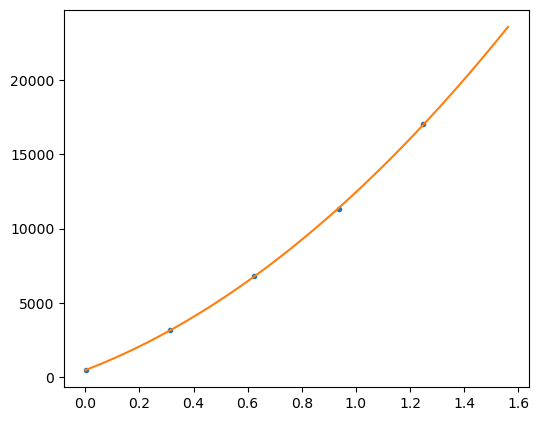

In [77]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 5), dpi=100)

I_rms = np.linspace(0,500,100)
axes.plot(np.sqrt(3)*V_ac*IGBT_5SNA_0400J650100[:,0]/1e6,IGBT_5SNA_0400J650100[:,1],'.')
axes.plot(np.sqrt(3)*V_ac*I_rms/1e6,4.89073990e-02*I_rms**2+2.17705101e+01*I_rms+ 4.65090148e+02)

In [ ]:
    axes[0].plot(grid_railway_droop.node_pos[it]/1e3,grid_railway_droop.voltages_dc[it], label = 'V', lw=0.08, color='#888888' )
    axes[1].plot(grid_railway_droop.node_pos[it]/1e3,grid_railway_droop.voltages_dc[it], label = 'V')

for ax in axes:
    #ax.set_ylim((-1,4))
    ax.grid()
    ax.set_ylabel('Voltages (V)')
    
line_trains = axes[1].plot([],[], 'o', label = 'trains')
axes[1].set_xlabel('Position (km)')
fig.tight_layout()
fig

In [ ]:
params_30A = {
 'a_i': 1.95773625,
 'b_i': 0.32430738,
 'c_i':-0.22694456,
 'd_i': 0.0155737 ,
 'e_i':-0.01093976,
 'a_d': 0.96302242,
 'b_d': 0.02653386,
 'c_d': 0.05055759,
 'd_d': 0.01328264,
 'e_d': 0.01394945,
 'R_th_igbt_sink': 0.5167999063238943,
 'R_th_diode_sink': 0.8394969099630814,
 'R_th_sink_a': 0.6619445743152772}

params = params_30A

a_i = params['a_i']
b_i = params['b_i']
c_i = params['c_i']
d_i = params['d_i']
e_i = params['e_i']
a_d = params['a_d']
b_d = params['b_d']
c_d = params['c_d']
d_d = params['d_d']
e_d = params['e_d']

m = 0.95
fp = 0.8
i_rms = np.linspace(0,30,600)
p_igbt  = a_i + (b_i - c_i*m*fp)*i_rms + (d_i - e_i*m*fp)*i_rms*i_rms
p_diode = a_d + (b_d - c_d*m*fp)*i_rms + (d_d - e_d*m*fp)*i_rms*i_rms

p_switch = p_igbt + p_diode
#print(f'p_switch = {p_switch} W')